In [1]:
%cd ../project/

C:\cygwin64\home\evger\thesis\project


In [2]:
import numpy as np
import pandas as pd

from hft.utils import logger
logger.to_file = True
logger.fmt_string = "%(message)s"


from hft.backtesting import backtest
from hft.backtesting.output import StorageOutput
from hft.utils.consts import QuoteSides
from hft.backtesting.readers import OrderbookReader, TimeLimitedReader
from hft.backtesting.strategy import CalmStrategy
from hft.units.metrics import VWAP_volume, DeltaTimeMetric, Lipton, HayashiYoshido
from hft.utils.data import OrderBook
from hft.units.filters import Filters

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from tqdm import tqdm

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [13]:
secs = 80
lipton_levels=8
hy = HayashiYoshido(seconds=secs)
lipton= Lipton(hy.name, lipton_levels)

In [14]:
hy_values = []
deltas = []
lipton_v = []
def store_only_yoshido(labels, ts, object):
  if 'hayashi-yoshido' == labels[0]:
    hy_values.append((ts, labels[1], *object))
  elif 'delta' in labels and hy.filter(object):
    deltas.append((ts, object, labels[-1]))
  elif 'lipton' in labels: 
    if object is not None:
        lipton_v.append((ts, labels[-2], *object))



In [15]:
reader = TimeLimitedReader(snapshot_file='../tests/resources/huge_dataset/orderbook_10_03_20.csv.gz', skip_time='20 min', limit_time='40 min')

hy_values = []
simulation = CalmStrategy(depth_filter = Filters.DepthFilter(5),delta_metrics=[hy], composite_metrics=[lipton])
storage = StorageOutput(instant_metric_names=[hy.name], time_metric_names=[])
storage.consume = store_only_yoshido

backtester = backtest.Backtest(reader, simulation, storage)
backtester.run(tqdm_enabled=True)

Current time: 2020-03-10 18:45:11.030000:   0%|          | 0/171773 [00:00<?, ?it/s]C:\cygwin64\home\evger\thesis\project\hft\units\metrics.py:341: RuntimeWarning: invalid value encountered in double_scalars
  return current_sum[symbol] / np.sqrt(current_sq[symbol][p]) / np.sqrt(current_sq[symbol][not p])
Current time: 2020-03-10 19:17:36.892000: : 171774it [01:20, 2146.83it/s]                          
Current time: 2020-03-10 19:24:33.789000: : 44703it [00:23, 1880.05it/s]                         


In [16]:
hy = pd.DataFrame(hy_values, columns=['date', 'symbol', 'hy', 'dr-side'])
hy.index = pd.DatetimeIndex(pd.to_datetime(hy.date))
hy.tail()

,date,symbol,hy,dr-side
date,,,,
2020-03-10 19:25:10.882,2020-03-10 19:25:10.882,XBTUSD,0.009250,1
2020-03-10 19:25:10.884,2020-03-10 19:25:10.884,XBTUSD,0.009250,1
2020-03-10 19:25:10.889,2020-03-10 19:25:10.889,ETHUSD,0.013304,2
2020-03-10 19:25:10.899,2020-03-10 19:25:10.899,XBTUSD,0.009788,1
2020-03-10 19:25:10.900,2020-03-10 19:25:10.900,XBTUSD,0.010055,1


In [17]:
# df_deltas = pd.DataFrame(deltas, columns=['date', ''])
ts, dlts, lbl = zip(*deltas)
dlts = list(map(lambda x: np.sum(x[-1][1, :]), dlts))
dlt_df = pd.DataFrame(zip(ts, dlts, lbl), columns=['date', 'delta', 'label'])
dlt_df.index = pd.DatetimeIndex(pd.to_datetime(dlt_df.date))
dlt_df.head()

,date,delta,label
date,,,
2020-03-10 18:45:11.118,2020-03-10 18:45:11.118,1500.0,ETHUSD
2020-03-10 18:45:11.124,2020-03-10 18:45:11.124,-9400.0,ETHUSD
2020-03-10 18:45:11.131,2020-03-10 18:45:11.131,-900.0,ETHUSD
2020-03-10 18:45:11.261,2020-03-10 18:45:11.261,20000.0,ETHUSD
2020-03-10 18:45:11.322,2020-03-10 18:45:11.322,2000.0,ETHUSD


In [18]:
lipton_df = pd.DataFrame(lipton_v, columns=['date', 'label', 'prob-up', 'prob-down'])
lipton_df.index = pd.DatetimeIndex(pd.to_datetime(lipton_df.date))
lipton_df.tail()

,date,label,prob-up,prob-down
date,,,,
2020-03-10 19:25:10.882,2020-03-10 19:25:10.882,XBTUSD,0.884029,0.884312
2020-03-10 19:25:10.884,2020-03-10 19:25:10.884,XBTUSD,0.884029,0.884312
2020-03-10 19:25:10.889,2020-03-10 19:25:10.889,ETHUSD,0.378258,0.377625
2020-03-10 19:25:10.899,2020-03-10 19:25:10.899,XBTUSD,0.878915,0.879176
2020-03-10 19:25:10.900,2020-03-10 19:25:10.900,XBTUSD,0.878930,0.879176


In [19]:
snapshots = reader._snapshots_df
snapshots = snapshots[[2, 3, 13, 23, 33]]
snapshots.columns = ['symbol', 'ask_price', 'ask_volume', 'bid_price', 'bid_volume']
snapshots.tail()

,symbol,ask_price,ask_volume,bid_price,bid_volume
0,,,,,
2020-03-10 19:25:10.894,XBTUSD,7912.50,260826,7912.0,1379936
2020-03-10 19:25:10.899,XBTUSD,7912.50,260951,7912.0,1379936
2020-03-10 19:25:10.900,XBTUSD,7912.50,261117,7912.0,1379936
2020-03-10 19:25:10.915,XBTUSD,7912.50,261117,7912.0,1379936
2020-03-10 19:25:10.954,ETHUSD,200.75,38235,200.7,55552


In [20]:
symbol = 'XBTUSD'

xbt_snap = snapshots[snapshots.symbol == symbol]
xbt_hy = hy[hy.symbol == symbol]
xbt_delta = dlt_df[dlt_df.label == symbol]
xbt_lipton = lipton_df[lipton_df.label == symbol]

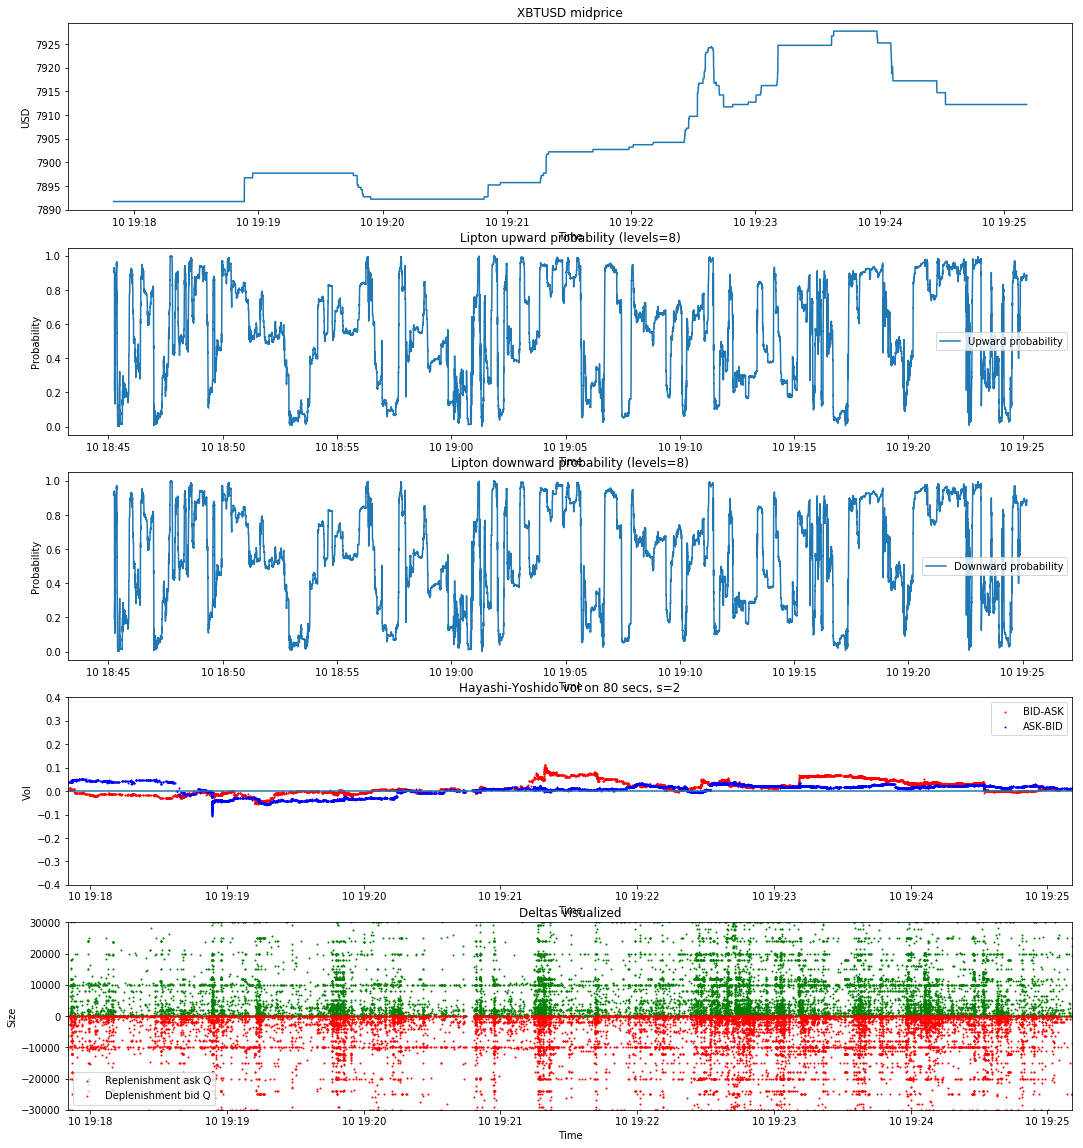

In [21]:
f = plt.figure(figsize=(18, 20))
prices = f.add_subplot(511)
prob = f.add_subplot(512)
prob2 = f.add_subplot(513)

vol = f.add_subplot(514)
bars = f.add_subplot(515)

_min = xbt_snap.index.min()
_max = xbt_snap.index.max()

prices.plot(xbt_snap.index, (xbt_snap.ask_price + xbt_snap.bid_price) / 2, label='prices')
prices.set(title=f'{symbol} midprice', xlabel='Time', ylabel='USD')

prob.plot(xbt_lipton.date, xbt_lipton['prob-up'], label='Upward probability')
prob2.plot(xbt_lipton.date, xbt_lipton['prob-down'], label='Downward probability')
prob.set(title=f'Lipton upward probability (levels={lipton_levels})', xlabel='Time', ylabel='Probability')
prob2.set(title=f'Lipton downward probability (levels={lipton_levels})', xlabel='Time', ylabel='Probability')

prob.legend()
prob2.legend()


for s, c, l in zip([1, 2], ['r','b'], ['BID-ASK', 'ASK-BID']):
    hy = xbt_hy[xbt_hy['dr-side'] == s]
    vol.scatter(hy.date, hy.hy, s=1, color=c, label=l)
    vol.set_xlim([_min, _max])
    vol.set_ylim([-0.4, 0.4])
    vol.set(title=f'Hayashi-Yoshido vol on {secs} secs, s={s}', xlabel='Time', ylabel='Vol')
vol.plot([_min, _max], [0, 0])
vol.legend()
# vol.add_line(line)


bars.scatter(dlt_df[dlt_df.delta > 0].date, dlt_df[dlt_df.delta > 0].delta, color='g', s=1, label='Replenishment ask Q')
bars.scatter(dlt_df[dlt_df.delta < 0].date, dlt_df[dlt_df.delta < 0].delta, color='r', s=1, label='Deplenishment bid Q')
bars.set_xlim([_min, _max])
bars.set_ylim([-30000, 30000])
bars.set(title='Deltas visualized', xlabel='Time', ylabel='Size')
bars.legend()
# plt.colorbar()
plt.show()

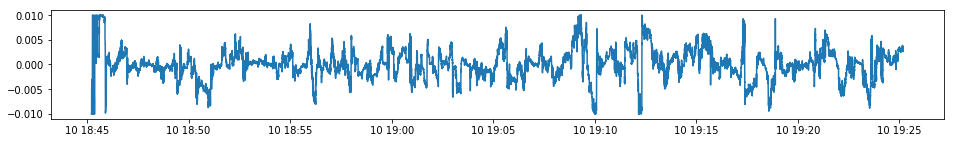

In [12]:
plt.figure(figsize=(16,2))
y = xbt_lipton['prob-up'] - xbt_lipton['prob-down']
plt.plot(xbt_lipton.date, np.clip(y, -0.01, 0.01))